# HANDS-ON PRACTICE: NEURAL NETWORKS FUNDAMENTALS

SO Basics of Neural Networks 2023 school at the IAA-CSIC. Nov 2023.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
University of Seville. Spain.  Dept. of CS and Artificial Inteligence


### Introduction

In this hands-on practice we are going to tackle an image classification problem, in concrete the Galaxy10 dataset. For educational purposes, we will design a MLP (Multilayer Perceptron) form scratch.

As you probably know, the Galaxy10 SDSS contains 21.785 galaxy colored images (69x69 pixels) separated in 10 classes. Galaxy10 SDSS images come from Sloan Digital Sky Survey and labels come from Galaxy Zoo.

Galaxy10 dataset (21785 images)  
├── Class 0 (3461 images): Disk, Face-on, No Spiral  
├── Class 1 (6997 images): Smooth, Completely round  
├── Class 2 (6292 images): Smooth, in-between round  
├── Class 3 (394 images): Smooth, Cigar shaped  
├── Class 4 (1534 images): Disk, Edge-on, Rounded Bulge  
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge  
├── Class 6 (589 images): Disk, Edge-on, No Bulge  
├── Class 7 (1121 images): Disk, Face-on, Tight Spiral  
├── Class 8 (906 images): Disk, Face-on, Medium Spiral  
└── Class 9 (519 images): Disk, Face-on, Loose Spiral  

These classes are mutually exclusive, Galaxy10 is meant to be an alternative to MNIST or Cifar10 as a deep learning toy dataset for astronomers. Thus astroNN.models.Cifar10_CNN is used with Cifar10 as a reference.

The original images are 424x424, but were cropped to 207x207 centered at the images and then downscaled 3 times via bilinear interpolation to 69x69 in order to make them manageable on most computer and graphics card memory.

There is no guarantee on the accuracy of the labels. Moreover, Galaxy10 is not a balanced dataset and it should only be used for educational or experimental purpose.


### 1. Loading libraries

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

### Exercise 0: Dataset preparation

First of all, we will download the dataset to our local disk. In this case our dataset can be downloaded from a site in the network. Typically this operation is easily performed using the `wget` command with this syntax:

```wget http_site_direction```

Note: OS commands can be called from jupyter notebooks inserting a `!` before the command. E. g. if we want to inspect the files in our directory:

```!ls -ls```

Our dataset can be downloaded from ```http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5```.

In [ ]:
# your code here

!wget http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2023-11-04 15:54:44--  http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  49.5MB/s    in 4.5s    

2023-11-04 15:54:48 (45.1 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



Now we have a h5 file in our local disk. It must be converted into numpy arrays to feed them to any machine learning model, including neural netowrks.

These numpy arrays are obtained reading this h5 file using the command:

```hf = h5py.File(file_name, 'r')```

This data structure is similar to a Python dictionary with two keys:
* ans: containing the labels.
* images: with the images.

Using the `get` command, this dictionary can be converted into numpy dataarrays.
A common use is:

```a = hf.get(key)[()]```

Create two numpy arrays containing images and labels from the previously downloaded h5 file.

In [ ]:
# your code here

hf = h5py.File('Galaxy10.h5', 'r')
labels, images = hf.get('ans')[()], hf.get('images')[()]

Check the shape of the dataset: number of images and its shape.

In [ ]:
# your code here

n_images, *shape, n_channels = images.shape
print(f"number of images: {n_images}")
print(f"shape of each image: {shape}")
print(f"number of channels: {n_channels}")

number of images: 21785
shape of each image: [69, 69]
number of channels: 3


MLP networks can not handle multichannel images. Hence, we will convert them into grayscale images. For that purpose, calculate the mean of the three layers

In [ ]:
# your code here

images_new = np.array([np.mean(image, axis=2) for image in images])
images_new.shape

(21785, 69, 69)

### Exercise 1. Create train and test datasets

Divide the dataset into two new datasets for:
* training: 90%
* test: 10%  

Use the `train_test_split` command from scikit_learn. Do not worry for the validation dataset. We will create it on-the-fly during the model training process.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Task:** Create the following arrays: `train_images`, `train_labels`, `test_images` and `test_labels`.

In [ ]:
# your code here

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images_new[train_idx], labels[train_idx], images_new[test_idx], labels[test_idx]

### Exercise 2. Normalize image pixel values

Remember that one of the great advantages of Deep Learning is a simplified preprocessing pipeline. In our case, only a normalization is needed, e.g. dividing all pixel values by their maximum value: 255.

**Task:** Divide train and test images by 255.0.

In [ ]:
# your code here

train_images = train_images/255.0
test_images = test_images/255.0

### Build the MLP model

Our next steps are related to the design of the MLP to solve the problem. Lets consider a simple 2 hidden layer architecture:

![picture](https://drive.google.com/uc?id=1RXlmNK1E_E2fbqNfiqKGvtfkWTKfElb1)




### Exercise 3. Create the input layer.

Remember:
* MLP can only process 1D arrays. Hence, images must be flattened.
* The number of neurons of the input layer is the number of features of each data sample. In image problems, each pixel of the image is a feature.  

More info in https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

**Task:** Create the input layer for our model

In [ ]:
# type your code here

flatten_layer = tf.keras.layers.Flatten(input_shape=[69,69],name='input_layer')

### Exercise 4. Create hidden layers.

Create two hidden layers:
* Follow the idea of a reduction of the dimensionality step by step.
* Remember that the hidden layers use relu as activation function.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

**Task:**  Create two layers with 500 and 100 neurons, respectively.

In [ ]:
# your code here

hidden_1 = tf.keras.layers.Dense(500,activation='relu',name='hidden_1')
hidden_2 = tf.keras.layers.Dense(100,activation='relu',name='hidden_2')

### Exercise 5. Create the output layer.

Do not forget:
* The number of neurons of this layer is the number of classes.
* Its activation function is sigmoid (if 2 classes) or softmax (if >2 classes)

**Task:** Create the proper output layer

In [ ]:
# your code here

output_layer = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')

### Exercise 6. Join all layers in a MLP

Remember: the first step is to create a `sequential` structure to be filled with the previously created layers.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

**Task:** Collect all the previous layers in a model

In [ ]:
# your code here

model = tf.keras.models.Sequential()

model.add(flatten_layer)
model.add(hidden_1)
model.add(hidden_2)
model.add(output_layer)

### Exercise 7. Inspect model

Show a summary of the model, with info of each layer:
* name and type of layer
* output shape
* number of parameters

This info is useful to check if the model has been built properly and, very important, to be conscious of the huge number of parameters to train.

**Task:** show a summary of the network


In [ ]:
# your code here

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Flatten)       (None, 4761)              0         
                                                                 
 hidden_1 (Dense)            (None, 500)               2381000   
                                                                 
 hidden_2 (Dense)            (None, 100)               50100     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 2432110 (9.28 MB)
Trainable params: 2432110 (9.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Exercise 8. Assign loss function and optimizer

Before training a model some details must be set:
* A loss function to be optimized. In classification problems, cross_entropy is considered:
    - 2 classes: binary cross entropy
    - +2 classes: categorical cross entropy

If the class label is not codified using one_hot, we use sparse_categorical_crossentropy.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

* An optimization "technique" to reduce the loss funtion up to a local minimum Typically, an adam optimizer is considered for training DL models.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

Task: Indicate to the netowrk the selected loss function and optimizer

In [ ]:
# your code here

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Exercise 9. Train the network

At this point, two final decision must be taken:
* How many epochs our model will be trained on. In this concrete problem, beyond 7 or 10 epochs there is no improvement.
* A validation dataset must be provided to the model. Typically 20% of the training dataset is more than enough for our purposes. Use the parameter `validation_split` to indicate this value to the model training.

You should obtain an accuracy on the validation dataset around 68-69%

**Task:** Train the model with the selected number of epochs and validation_split parameter.

In [ ]:
# your code here

history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
491/491 [==============================] - 10s 19ms/step - loss: 1.3703 - accuracy: 0.5064 - val_loss: 1.1116 - val_accuracy: 0.6135
Epoch 2/10
491/491 [==============================] - 10s 20ms/step - loss: 1.0698 - accuracy: 0.6213 - val_loss: 1.0277 - val_accuracy: 0.6321
Epoch 3/10
491/491 [==============================] - 10s 21ms/step - loss: 0.9798 - accuracy: 0.6475 - val_loss: 1.0287 - val_accuracy: 0.6400
Epoch 4/10
491/491 [==============================] - 10s 21ms/step - loss: 0.9351 - accuracy: 0.6655 - val_loss: 0.9706 - val_accuracy: 0.6545
Epoch 5/10
491/491 [==============================] - 11s 21ms/step - loss: 0.8989 - accuracy: 0.6786 - val_loss: 0.9102 - val_accuracy: 0.6736
Epoch 6/10
491/491 [==============================] - 10s 20ms/step - loss: 0.8624 - accuracy: 0.6912 - val_loss: 0.8822 - val_accuracy: 0.6864
Epoch 7/10
491/491 [==============================] - 10s 20ms/step - loss: 0.8291 - accuracy: 0.7018 - val_loss: 0.8528 - val_accuracy:

### Exercise 10: Plot training history

It is a good practice to plot our training curves. Typically we compare the evolution of loss function (accuracy) vs epochs.

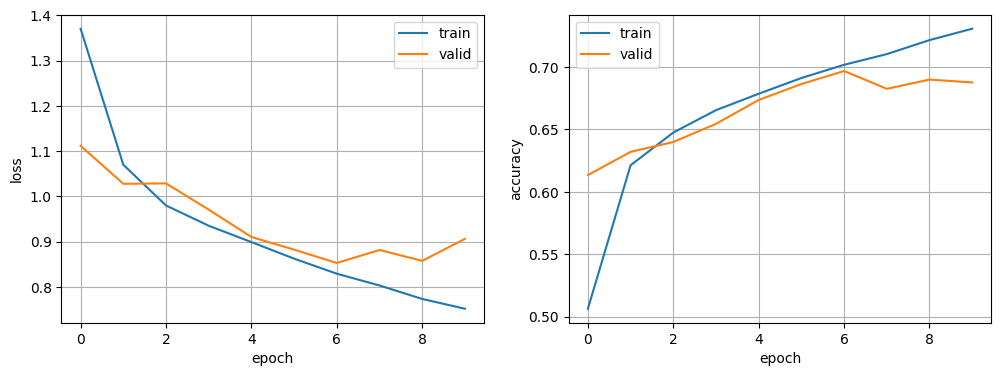

In [ ]:
# your code here

df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();

### Exercise 11. Evaluate model accuracy

**Task:** Once trained the model, obtain the accuracy of the model on the test dataset.

In [ ]:
# your code here

res = model.evaluate(test_images,test_labels, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.68


### Exercise 12: Making predictions with the model

Given an input image, the `predict` method returns the output of the last layer. This output is interpreted as the probability of the image to correspond to each of the classes.

**Task:** Inject to the model 3 images from the test dataset to obtain their probabilities.

In [ ]:
# your code here

X_new = test_images[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 98ms/step


array([[0.03, 0.  , 0.95, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.03, 0.97, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.01, 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Task:** Using `np.argmax` and the probabilities, decide which is the class of each image

In [ ]:
# your code here

y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([2, 1, 4])

Task: Finally, compare the predicted classes with the real ones. There should be approx. 2/3 of correct predictions (or if we are lucky, even more).

In [ ]:
# your code here

test_labels[:3]

array([2, 1, 4], dtype=uint8)